# IMPORT LIBRAIRIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# from utils.load_custom_filters_for_primer2 import get_filters_multi_scale

np.set_printoptions(precision=3, suppress=True)

In [2]:
PATCH_SIZE = 4
FILTER_THRESHOLD = 0.7
CLUSTER_DISTANCE = 3

# LOAD DATA

In [328]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# lmks_pos = np.load("_lmk_pos_train65.npy")
lmks_pos = np.load("_lmk_pos_train130.npy")
lmks_pos = np.load("_lmk_pos_train150.npy")
print("Loaded {} primers".format(len(lmks_pos)))
num_digits = int(np.amax(lmks_pos[:, 0]))
print("num_digits:", num_digits)
n_cat = int(np.amax(lmks_pos[:, 3]))
print("n_cat:", n_cat)

Loaded 714 primers
num_digits: 149
n_cat: 12


## display digits

In [350]:
# label digits
lmks_pos = []
lmks_pos.append([150, 8, 15, 11])
lmks_pos.append([150, 15, 7, 9])
lmks_pos.append([150, 17, 14, 12])
lmks_pos.append([150, 24, 14, 2])
lmks_pos.append([150, 15, 23, 3])
print("shape lmks_pos", np.shape(lmks_pos))
lmks_pos = np.array(lmks_pos)

shape lmks_pos (5, 4)


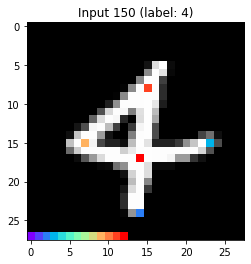

In [351]:
colors = cm.rainbow(np.linspace(0, 1, n_cat + 1))
digits = [150]

# plot primers on digit
for d in digits:
    plt.figure()

    test_image = x_train[d]
    rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

    # retrieve primers
    primers = lmks_pos[lmks_pos[:, 0] == d]

    for primer in primers:
        color = colors[int(primer[3])]
        rgb_im[np.round(primer[1]).astype(int), np.round(primer[2]).astype(int)] = color[:3] * 255

    # plot legend
    for i in range(n_cat + 1):
        color = colors[i]
        rgb_im[-1, i] = color[:3] * 255

    plt.title("Input {} (label: {})".format(d, y_train[d]))
    plt.imshow(rgb_im)

# SAVE NEW LABELS

In [327]:
lmks_pos_to_extend = np.load("_lmk_pos_train130.npy")
# lmks_pos_to_extend = np.round(np.load("_lmk_pos_train65.npy")).astype(int)
# lmks_pos_to_extend[:, [2, 1]] = lmks_pos_to_extend[:, [1, 2]]  # swap positions for train_65
print("shape lmks_pos_to_extend", np.shape(lmks_pos_to_extend))
print("shape new lmks", np.shape(lmks_pos))
lmks_pos_to_add = np.copy(lmks_pos)
lmks_pos_to_add[:, [2, 1]] = lmks_pos_to_add[:, [1, 2]]  # swap positions for train_65
new_lmks_pos = np.concatenate((lmks_pos_to_extend, lmks_pos_to_add))
print("shape new_lmks_pos", np.shape(new_lmks_pos))
n_digits = int(np.amax(new_lmks_pos[:, 0])) + 1
print("n_digits:", n_digits)
np.save("lmk_pos_train{}".format(n_digits), new_lmks_pos)
print("new digits lmks pos saved!")

shape lmks_pos_to_extend (603, 4)
shape new lmks (111, 4)
shape new_lmks_pos (714, 4)
n_digits: 150
new digits lmks pos saved!


# BUILD PRIMERS

In [24]:
def simple_patch_wh_neg_value(filter, patch, thresh_activation, neg_factor):
    # compute the number of zeros within the patch
    n_zeros = np.count_nonzero(patch == 0)

    # compute alpha factor to reach the thresh_value
    max_matching_val = np.sum(filter * patch)
    alpha = thresh_activation / max_matching_val

    # normalize filter
    filter *= alpha

    # set filter to neutral with the zeros
    offset_neg_val = - neg_factor * np.sum(filter) / n_zeros
    filter[filter == 0] = offset_neg_val

    return filter


def build_primer(idx, lmk_pos, thresh_val=0.75, filt_size=(7, 7), neg_factor=6):
    """

    :param lmk_pos: nx4 matrix, with 4 the following parameters: 0: idx of the mnsit img, 1: posX, 2: posX, 3: n_rotate
    :param thresh_val:
    :param filt_size:
    :param neg_factor: value to which the negative parts of the filters get multiplied
    :return:
    """
    pad_x = int(filt_size[0] / 2)
    pad_y = int(filt_size[1] / 2)

    # define start and stop
    start_x = lmk_pos[0]-pad_x
    end_x = lmk_pos[0]+pad_x+1
    start_y = lmk_pos[1]-pad_y
    end_y = lmk_pos[1]+pad_y+1
    # print(start_x, end_x, start_y, end_y)

    # define filter for primer
    img = x_train[idx] / 255.
    patch = img[np.maximum(start_x, 0):end_x, np.maximum(start_y, 0):end_y]

    # add zeros if patch is smaller than the dimension
    if start_x < 0:
        zeros_patch = np.zeros((filt_size[0] - np.shape(patch)[0], np.shape(patch)[1]))
        patch = np.vstack([zeros_patch, patch])
    elif end_x > np.shape(img)[0]:
        zeros_patch = np.zeros((end_x - np.shape(img)[0], np.shape(patch)[1]))
        patch = np.vstack([patch, zeros_patch])
    if start_y < 0:
        zeros_patch = np.zeros((np.shape(patch)[0], filt_size[1] - np.shape(patch)[1]))
        patch = np.hstack([zeros_patch, patch])
    elif end_y > np.shape(img)[1]:
        zeros_patch = np.zeros((np.shape(patch)[0], end_y - np.shape(img)[1]))
        patch = np.hstack([patch, zeros_patch])

    # create filter
    filter = np.copy(patch)

    # control size
    if np.shape(filter)[0] != filt_size[0]:
        print("Dimension 0 of patch is not matching ,expected {}, received {}".format(filt_size[0], np.shape(patch)[0]))
    if np.shape(filter)[1] != filt_size[1]:
        print("Dimension 1 of patch is not matching ,expected {}, received {}".format(filt_size[1], np.shape(patch)[1]))

    # build filter
    filter = simple_patch_wh_neg_value(filter, patch, thresh_val, neg_factor)
    # filter = simple_ones_patch_wh_neg_value(filter, patch, thresh_val, neg_factor)

    return filter

In [25]:
def get_filters(lmks, n_types, group_types=None, filt_size=(7, 7), thresh_val=0.75, neg_factor=6, verbose=False):
    # count the number of filter there's per type/group
    filter_counts = np.zeros(n_types)
    for i in range(n_types):
        # count number of filter per group
        filter_counts[i] = len(lmks[lmks[:, 3] == i])
    n_max_filter = int(np.amax(filter_counts))

    if group_types is not None:
        n_groups = len(group_types)
        filter_group_counts = np.zeros(n_groups)
        for i in range(n_groups):
            for j in range(len(group_types[i])):
                filter_group_counts[i] += filter_counts[group_types[i][j]]
        # get max number of filters
        n_max_filter = int(np.amax(filter_group_counts))

    if verbose:
        print("filteer counts")
        print(filter_counts)
        if group_types is not None:
            print("filter_group_counts", filter_group_counts)

    # declare filters
    filters = np.zeros((n_types, filt_size[0], filt_size[1], n_max_filter))

    n_type_counter = np.zeros(n_types)
    for lmk in lmks:
        # build filter
        filt = build_primer(int(lmk[0]), [int(np.round(lmk[2])), int(np.round(lmk[1]))], filt_size=filt_size)

        # get filter type
        lmk_type = int(lmk[3])

        # rotate to extend by group type
        if group_types is not None:
            n_types_in_group = None
            lmk_group_type = None

            # get in which group this category belong
            for i in range(n_groups):
                if lmk_type in group_types[i]:
                    n_types_in_group = len(group_types[i])
                    lmk_group_type = i

            if n_types_in_group is None:
                print("issue with group type not found!")

            if verbose:
                print("lmk_type {}, turned {} time(s)".format(lmk_type, (n_types_in_group - lmk_type) % n_types_in_group))
            filt = np.rot90(filt, (n_types_in_group - lmk_type) % n_types_in_group)

            # append all the filters to the group
            for t, type in enumerate(group_types[lmk_group_type]):
                filt_rot = np.rot90(filt, t)
                filters[type, ..., int(n_type_counter[type])] = filt_rot
                n_type_counter[type] += 1

        else:
            filters[lmk_type, ..., n_type_counter[lmk_type]] = filt
            n_type_counter[lmk_type] += 1

    return filters

In [26]:
# build filters
group_types = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12]]
filters = get_filters(lmks_pos[:8], 13, group_types=group_types, filt_size=(9, 9), thresh_val=0.75, neg_factor=6, verbose=False)
print("shape filters", np.shape(filters))

shape filters (13, 9, 9, 4)


# COMPUTE PRIMER POSITIONS

In [27]:
def compute_center_of_activity(ft_map, verbose=False):
    # initialize indices (x, y) for each entry
    indices = np.arange(np.shape(ft_map)[0])

    # compute weighted average of the activity, weighted by the indices
    average_x = np.average(ft_map, axis=1, weights=indices)
    average_y = np.average(ft_map, axis=0, weights=indices)

    # compute mean of each pos
    center_x = np.sum(average_x) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=1))
    center_y = np.sum(average_y) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=0))

    if verbose:
        print("feat_map")
        print(ft_map)
        print("center ({}, {})".format(center_x, center_y))

    return center_x, center_y

In [28]:
def find_primer(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False, plot_title=""):
    # convert image to tensor
    if len(np.shape(image)) == 2:
        image = np.expand_dims(image, axis=[0, 3])
    else:
        print("image shape is wrong! Expected 2 got ", len(np.shape(image)))
    image = tf.convert_to_tensor(image, dtype='float32')

    # control filters
    if len(np.shape(filters)) == 2:
        filters = np.expand_dims(filters, axis=[2, 3])
    elif len(np.shape(filters)) == 3:  # multi scale
        filters = np.expand_dims(filters, axis=2)
    tf.convert_to_tensor(filters, dtype='float32')

    # apply convolution
    primers = tf.nn.conv2d(image, filters, strides=1, padding='SAME', name="conv1")

    if verbose:
        print("min max patch", np.min(primers), np.max(primers))
        print("shape primers", np.shape(primers))
        max_per_filt = np.amax(primers, axis=(0, 1, 2))
        max_arg_idx = np.flip(np.argsort(max_per_filt)[-5:])
        print("filter idx:", max_arg_idx)
        print("filter value:", max_per_filt[max_arg_idx])

    # filters primers and discard the one under the threshold
    filt_primers = primers.numpy()
    filt_primers = np.amax(filt_primers, axis=(0, -1))
    filt_primers = np.expand_dims(filt_primers, axis=[0, 3])
    filt_primers[filt_primers < threshold] = 0
    if np.max(filt_primers) > 1:
        print("Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity")
        filt_primers[filt_primers > 1] = 1.0

    # split in patches
    patches = tf.image.extract_patches(
        images=filt_primers,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()

    # show each patch
    if do_plot:
        plt.figure()
        plt.title("patch " + plot_title)
        n_patch_x = np.shape(patches)[1]
        n_patch_y = np.shape(patches)[2]
        for i in range(n_patch_x):
            for j in range(n_patch_y):
                patch = np.reshape(patches[0, i, j], [patch_size, patch_size])
                rgb_patch = np.repeat(np.expand_dims(patch, axis=2), 3, axis=2)
                plt.subplot(n_patch_x, n_patch_y, i*np.shape(patches)[2] + j + 1)
                plt.axis('off')
                plt.imshow(rgb_patch)
                # print("min max patch", np.min(patch), np.max(patch))

    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                if verbose:
                    print()
                    print("p:", plot_title)

                coa = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([coa[0] + j*patch_size, coa[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    if do_plot:
        # plot primers
        plt.figure()
        plt.title("primers " + plot_title)
        rgb_image = np.repeat(np.expand_dims(filt_primers[0, ..., 0], axis=2), 3, axis=2)
        for center in centers:
            rgb_image[int(round(center[1])), int(round(center[0]))] = [1.0, 0, 0]
        plt.imshow(rgb_image)

    return centers, max_patch

In [29]:
# compute all primers
def find_primers(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False):
    n_primer = 0
    primers = {}

    for p, filt in enumerate(filters):
        if verbose:
            print("filt p", p)

        primers_pos, max_patch = find_primer(image, filt,
                                             patch_size=patch_size,
                                             threshold=threshold,
                                             do_plot=do_plot,
                                             verbose=verbose,
                                             plot_title=str(p))

        if len(primers_pos) > 0:
            for i in range(len(primers_pos)):
                primers[n_primer] = {"type": p, "pos": primers_pos[i], "max": max_patch[i]}
                n_primer += 1

            if verbose:
                print("primers_pos")
                print(primers_pos)
                print("max patch")
                print(max_patch)
        if verbose:
            print()

    return primers

In [34]:
# normalize input and filters
test_image = x_train[130]
primers_dict = find_primers(test_image / 255., filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=False, verbose=True)
print("primers_dict")
for p in primers_dict:
    print(primers_dict[p])

filt p 0
min max patch -2.5702882 0.14340542
shape primers (1, 28, 28, 4)
filter idx: [0 1 3 2]
filter value: [0.143 0.13  0.    0.   ]

filt p 1
min max patch -2.764151 0.75
shape primers (1, 28, 28, 4)
filter idx: [1 0 3 2]
filter value: [0.75 0.75 0.   0.  ]

p: 1
feat_map
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.75 0.   0.   0.  ]]
center (0.0, 2.9999933242946404)

p: 1
feat_map
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.75 0.   0.   0.  ]]
center (0.0, 2.9999933242946404)
primers_pos
[[8.0, 6.999993324294641], [8.0, 22.99999332429464]]
max patch
[0.75, 0.75]

filt p 2
min max patch -2.7036784 0.16706596
shape primers (1, 28, 28, 4)
filter idx: [0 1 3 2]
filter value: [0.167 0.015 0.    0.   ]

filt p 3
min max patch -3.4125752 0.26139164
shape primers (1, 28, 28, 4)
filter idx: [0 1 3 2]
filter value: [0.261 0.258 0.    0.   ]

filt p 4
min max patch 0.0 0.0
shape primers (1, 28, 28, 4)
filter idx: [3 2 1 0]
filter valu

In [35]:
def max_pool_primers(primers, dist_threshold=3, sorting='max', verbose=False):
    """
    filter primers with surroundings, i.e. if a primer is within a distance smaller than another one, keep the highest

    :param primers:
    :return:
    """

    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(primers)):
        for p_a in range(p_t + 1, len(primers)):  # only upward diagonal
            # get primers
            p_target = primers[p_t]
            p_agent = primers[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in primers:
        if p not in discarded_primer_idx:
            primer = primers[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [36]:
filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=True)
print("filt_primers", len(filt_primers))
for p in filt_primers:
    print(filt_primers[p])

distance 15.999999999999998
distance 7.21109911241274
distance 9.219543474611068
distance 16.401222044683102
distance 9.05538358473695
distance 13.416405732524316
distance 10.81664946212453
distance 10.440300327884605
distance 17.49284877440355
distance 3.000002145763631
distance 9.84886361971197
distance 4.242637540165547
distance 7.211106033526399
distance 6.708200982575384
distance 12.0415944005966
discarded primers
[]
filt_primers 6
{'type': 1, 'pos': [8.0, 6.999993324294641], 'max': 0.75}
{'type': 1, 'pos': [8.0, 22.99999332429464], 'max': 0.75}
{'type': 8, 'pos': [13.999995708474103, 10.999993562711154], 'max': 0.7499999}
{'type': 9, 'pos': [13.999995708474785, 13.999995708474785], 'max': 0.75}
{'type': 10, 'pos': [17.99999554952976, 20.0], 'max': 0.75}
{'type': 11, 'pos': [16.99999769529238, 8.0], 'max': 0.75}


primer (0) type: 1  (7, 8)
primer (1) type: 1  (23, 8)
primer (2) type: 8  (11, 14)
primer (3) type: 9  (14, 14)
primer (4) type: 10  (20, 18)
primer (5) type: 11  (8, 17)


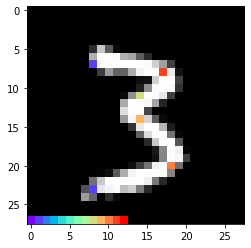

In [37]:
# plot primers on digit
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, np.shape(filters)[0]))
rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

for p in filt_primers:
    primer = filt_primers[p]
    primer_type = primer["type"]
    primer_pos = primer["pos"]
    print("primer ({}) type: {}  ({}, {})".format(p, primer_type, np.round(primer_pos[1]).astype(int), np.round(primer_pos[0]).astype(int)))
    color = colors[primer_type]
    rgb_im[np.round(primer_pos[1]).astype(int), np.round(primer_pos[0]).astype(int)] = color[:3] * 255

# plot legend
for i in range(np.shape(filters)[0]):
    color = colors[i]
    rgb_im[-1, i] = color[:3] * 255

plt.imshow(rgb_im)